<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/GAN/GAN_108_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bias

The notebook implements code to evaluate GANs

Here are the main features

* Be able to distinguish a few different kinds of bias in terms of demographic parity, equality of odds, and equality of opportunity (as proposed here).
* Be able to use a classifier to try and detect biases in a GAN by analyzing the generator's implicit associations.


---

### Task
Celeb Dataset, BIAS.

### Reference
https://nbviewer.org/github/amanchadha/coursera-gan-specialization/blob/main/C2%20-%20Build%20Better%20Generative%20Adversarial%20Networks/Week%202/C2W2_Assignment.ipynb

## Getting Started

### Packages and Visualization


In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Generator and Noise


In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

### classfier

In [3]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is your default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing classes.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

### Specifying Parameters


In [6]:
z_dim = 64
batch_size = 128
device = 'cuda'

### Loading the Pre-trained Models

You can now load the pre-trained generator (trained on CelebA) and classifier using the following code. If you trained your own classifier, you can load that one here instead. However, it is suggested that you first go through the assignment using the pre-trained one.

In [8]:
!git clone https://github.com/pankajr141/experiments.git
!unzip experiments/Reasoning/GAN/pretrained_models/pretrained_celeba.pth.zip
!unzip experiments/Reasoning/GAN/pretrained_models/pretrained_classifier.pth.zip

Cloning into 'experiments'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 325 (delta 80), reused 26 (delta 10), pack-reused 167
Receiving objects: 100% (325/325), 85.21 MiB | 19.66 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Archive:  experiments/Reasoning/GAN/pretrained_models/pretrained_celeba.pth.zip
  inflating: pretrained_celeba.pth   
Archive:  experiments/Reasoning/GAN/pretrained_models/pretrained_classifier.pth.zip
  inflating: pretrained_classifier.pth  


In [9]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


### Feature Correlation

We can generate images using the generator. By also using the classifier, we will be generating images with different amounts of the "male" feature.

In [10]:
# First you generate a bunch of fake images with the generator
n_images = 256
fake_image_history = []
classification_history = []
grad_steps = 30 # How many gradient steps to take
skip = 2 # How many gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

target_feature = "Male" # Set the target feature
target_indices = feature_names.index(target_feature)

noise = get_noise(n_images, z_dim).to(device)
new_noise = noise.clone().requires_grad_()
starting_classifications = classifier(gen(new_noise)).cpu().detach()

# Additive direction (more of a feature)
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]  # saving image
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data += new_noise.grad / grad_steps

# Subtractive direction (less of a feature)
new_noise = noise.clone().requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake] # saving image
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data -= new_noise.grad / grad_steps

classification_history = torch.stack(classification_history)



We've now generated image samples, which have increasing or decreasing amounts of the target feature. We can visualize the way in which that affects other classified features. The x-axis will show you the amount of change in our target feature and the y-axis shows how much the other features change, as detected in those images by the classifier. Together, we will be able to see the covariance of "male-ness" and other features.

We started off with a set of features that have interesting associations with "male-ness", but we are welcome to change the features in other_features with others from feature_names.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

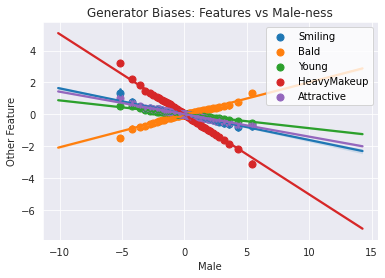

In [11]:
import seaborn as sns
# Set the other features
other_features = ["Smiling", "Bald", "Young", "HeavyMakeup", "Attractive"]
classification_changes = (classification_history - starting_classifications[None, :, :]).numpy()
for other_feature in other_features:
    other_indices = feature_names.index(other_feature)
    with sns.axes_style("darkgrid"):
        sns.regplot(
            classification_changes[:, :, target_indices].reshape(-1), 
            classification_changes[:, :, other_indices].reshape(-1), 
            fit_reg=True,
            truncate=True,
            ci=99,
            x_ci=99,
            x_bins=len(classification_history),
            label=other_feature
        )
plt.xlabel(target_feature)
plt.ylabel("Other Feature")
plt.title(f"Generator Biases: Features vs {target_feature}-ness")
plt.legend(loc=1)
plt.show()

This correlation detection can be used to reduce bias by penalizing this type of correlation in the loss during the training of the generator. However, currently there is no rigorous and accepted solution for debiasing GANs. A first step that you can take in the right direction comes before training the model: make sure that your dataset is inclusive and representative, and consider how you can mitigate the biases resulting from whatever data collection method you used—for example, getting a representative labelers for your task.

A diverse dataset alone is not enough to eliminate bias. Even diverse datasets can reinforce existing structural biases by simply capturing common social biases. Mitigating these biases is an important and active area of research.

**Note on CelebA**
You may have noticed that there are obvious correlations between the feature you are using, "male", and other seemingly unrelates features, "smiling" and "young" for example. This is because the CelebA dataset labels had no serious consideration for diversity. The data represents the biases their labelers, the dataset creators, the social biases as a result of using a dataset based on American celebrities, and many others.

### Quantification

Given a target index, for example corresponding to "male," you'll want to return the other features that covary with that target feature the most. You'll want to account for both large negative and positive covariances, and you'll want to avoid returning the target feature in your list of covarying features (since a feature will often have a high covariance with itself).

In [12]:
from torch.distributions import MultivariateNormal
def covariance_matrix_from_examples(examples):
    """
    Helper function for get_top_covariances to calculate a covariance matrix. 
    Parameter: examples: a list of steps corresponding to samples of shape (2 * grad_steps, n_images, n_features)
    Returns: the (n_features, n_features) covariance matrix from the examples
    """
    return np.cov(examples.reshape(-1, examples.shape[2]), rowvar=False)

# helper function to return the indices of a numpy array in order of magnitude.
def get_top_magnitude_indices(values):
    """
    Helper function for get_top_covariances to get indices by magnitude. 
    Parameter: values, a list of values as a numpy array of shape (n_values)
    Returns: numpy array of indices sorted from greatest to least by the magnitudes of their corresponding values
    """
    top_indices = np.abs(values).argsort()[::-1]
    return top_indices

# helper function to return a list with an element removed by the value, in an unchanged order.
def remove_from_list(indices, index_to_remove):
    """
    Helper function for get_top_covariances to remove an index from an array. 
    Parameter: indices, a list of indices as a numpy array of shape (n_indices)
    Returns: the numpy array of indices in the same order without index_to_remove
    """
    new_indices = np.delete(indices, np.where(indices ==index_to_remove))
    return new_indices

In [15]:
# putting above functions together
def get_top_covariances(classification_changes, target_index, top_n=10):
    '''
    Function for getting the top n covariances: Given a list of classification changes
    and the index of the target feature, returns 
    (1) relevant_indices: a list or tensor (numpy or torch) of the indices corresponding 
        to the n features that covary most with the target in terms of absolute covariance
    (2) highest_covariances: a list or tensor of the degrees to which they covary.
    Parameters:
        classification_changes: relative changes in classifications of each generated image 
          resulting from optimizing the target feature (see above for a visualization)
        target_index: the index of the target feature, a scalar
        top_n: the top most number of elements to return, default is 10
    '''
    cov_matrix = covariance_matrix_from_examples(classification_changes)
    relevant_indices = get_top_magnitude_indices(cov_matrix[target_index, :])
    #relevant_indices = remove_from_list(relevant_indices, target_index) # uncomment to remove Male from printing
    relevant_indices = relevant_indices[:top_n]
    highest_covariances = cov_matrix[:, relevant_indices][target_index]
    return relevant_indices, highest_covariances

print top related(+ve) and unrelated(-ve) features

In [16]:
relevant_indices, highest_covariances = get_top_covariances(classification_changes, target_indices, top_n=10)
print(relevant_indices)
for index, covariance in zip(relevant_indices, highest_covariances):
    print(f"{feature_names[index]}  {covariance:f}")

[20 36 18 24  0 30 22 16 38  9]
Male  4.691558
WearingLipstick  -2.550308
HeavyMakeup  -2.362170
NoBeard  -2.208743
5oClockShadow  1.809830
Sideburn  1.737517
Mustache  1.723912
Goatee  1.636087
WearingNecktie  1.492556
BlondHair  -1.123135
